In [13]:
import os
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/se-net-pretrained-imagenet-weights/* /root/.cache/torch/hub/checkpoints/
import torch as tc 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
import os,sys,cv2
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt
import albumentations as A
!python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from glob import glob

Looking in links: /kaggle/input/pip-download-for-segmentation-models-pytorch
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/segmentation_models_pytorch-0.3.3-py3-none-any.whl
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/pretrainedmodels-0.7.4.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/efficientnet_pytorch-0.7.1.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/timm-0.9.2-py3-none-any.whl (from segmentation-models-pytorch)
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/munch-4.0.0-py2.py3-none-any.whl (from pretrainedmodels==0.7.4->segmentation-models-pytorch)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=cb910b7c3056ea6d4b3eed999ebc3476d93b0

In [3]:
directory_path_train = '/kaggle/input/blood-vessel-segmentation/train'

def list_files_in_directory(directory_path=directory_path_train):
    direc = []
    for root, dirs, files in os.walk(directory_path):
        for dire in dirs:
            if dire in ["labels","images"]:
                continue
            file_path = os.path.join(root, dire)
            direc.append(file_path)
            print(file_path)
    return direc

train_folders = list_files_in_directory(directory_path_train)


/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense
/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense
/kaggle/input/blood-vessel-segmentation/train/kidney_2
/kaggle/input/blood-vessel-segmentation/train/kidney_1_voi
/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse


In [5]:
import os
import random

def count_and_list_img_folders(folders):
    sub_folders = ["images", "labels"]
    path_with_counts = []
    total_files = []
    just_paths = []  # List to hold just the paths without counts

    for dire in folders:
        for subf in sub_folders:
            current_path = os.path.join(dire, subf)

            # Skipping specific directory and subfolder condition
            if "kidney_3_dense/images" in current_path:
                continue

            try:
                total_sample = len(os.listdir(current_path))
                print(f"{current_path}: {total_sample}")
                #print('\n')
                path_with_counts.append(current_path)
                total_files.append(total_sample)
                just_paths.append(current_path)  # Add path without count
            except FileNotFoundError:
                print(f"Directory not found: {current_path}")
                continue

    return {
        "detailed_info": {
            "path": path_with_counts,
            "total_files": total_files
        },
        "paths_only": just_paths
    }

# Example usage
# Assuming 'train_folders' is a list of your root dataset directories
train_file_dir = count_and_list_img_folders(train_folders)

# This will print only the paths without counts
print("Folders without counts:")
for path in train_file_dir["paths_only"]:
    #print('\n')
    print(path)


/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense/labels: 501
/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images: 2279
/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels: 2279
/kaggle/input/blood-vessel-segmentation/train/kidney_2/images: 2217
/kaggle/input/blood-vessel-segmentation/train/kidney_2/labels: 2217
/kaggle/input/blood-vessel-segmentation/train/kidney_1_voi/images: 1397
/kaggle/input/blood-vessel-segmentation/train/kidney_1_voi/labels: 1397
/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images: 1035
/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/labels: 1035
Folders without counts:
/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense/labels
/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images
/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels
/kaggle/input/blood-vessel-segmentation/train/kidney_2/images
/kaggle/input/blood-vessel-segmentation/train/kidney_2/labe

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


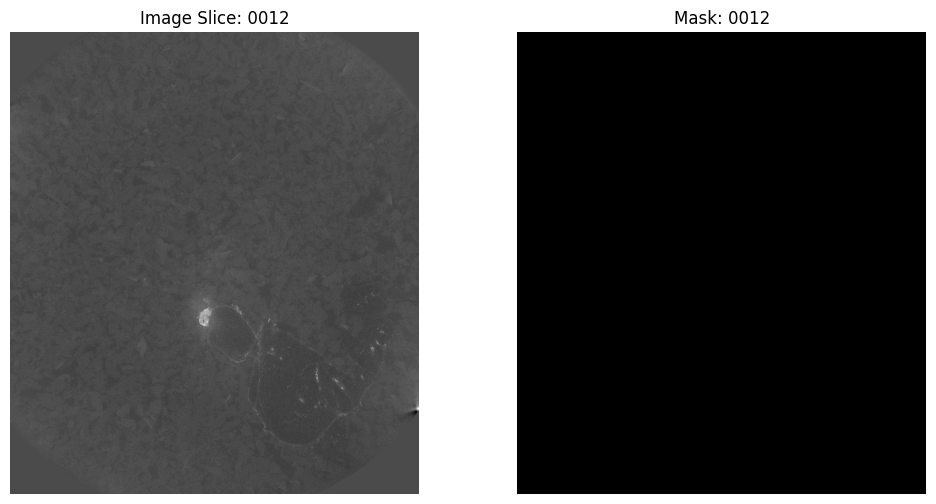

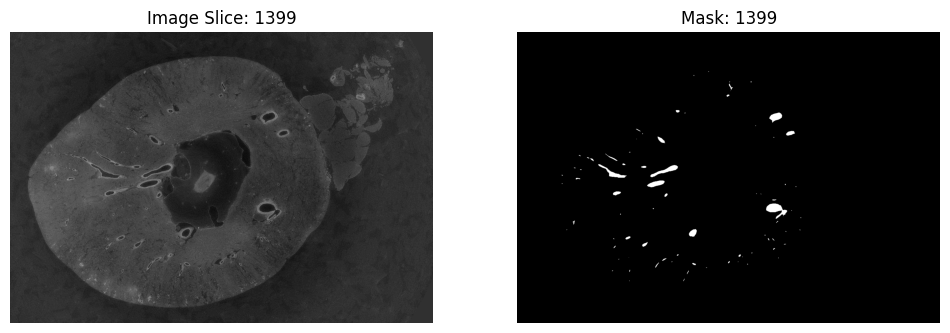

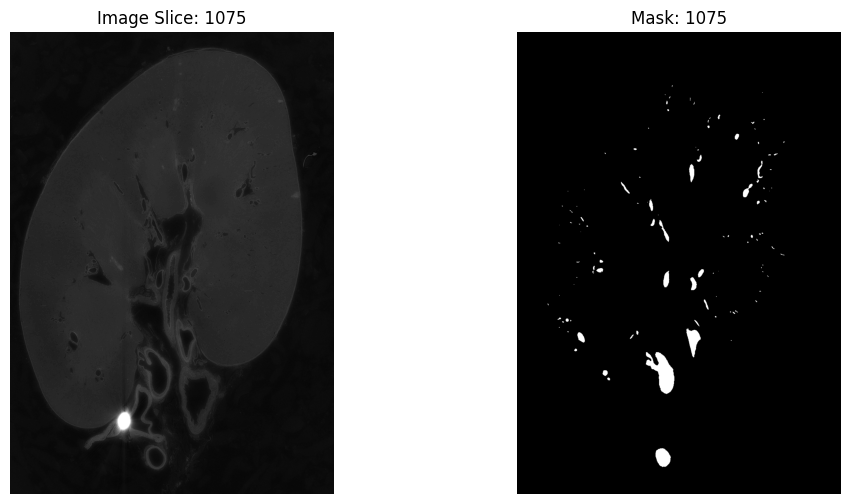

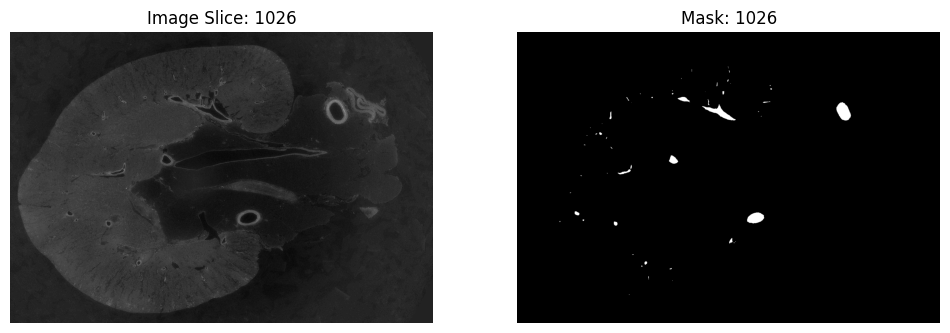

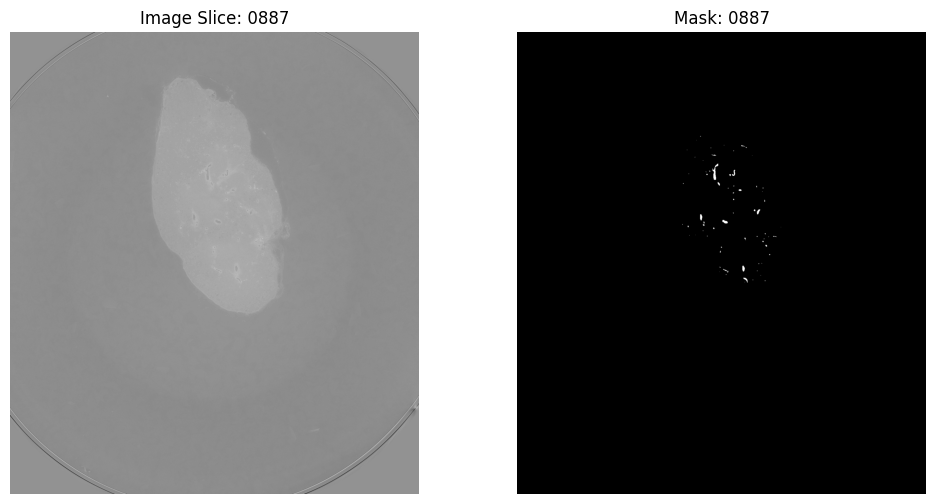

In [6]:
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread

def display_random_images(folders_info, num_images=10):
    """
    Displays random image slices with their corresponding masks side by side.

    Args:
    - folders_info (dict): A dictionary containing 'path' and 'total_files' keys.
    - num_images (int): Number of image-mask pairs to display.
    """
    for _ in range(num_images):
        # Choose a random directory (either images or labels)
        paths_info = list(zip(folders_info['detailed_info']['path'], folders_info['detailed_info']['total_files']))
        selected_path_info = random.choice(paths_info)

        # Selecting a random image number based on total files available
        img_index = random.randint(0, selected_path_info[1] - 1)
        img_number = f"{img_index:04}"

        # Constructing image and label paths
        base_path = selected_path_info[0]
        img_path = os.path.join(base_path, img_number + ".tif")

        # Adjust paths for images and labels
        if "labels" in base_path:
            label_path = img_path
            img_path = img_path.replace("labels", "images")
        else:
            label_path = img_path.replace("images", "labels")

        # Special case handling for "kidney_3_dense"
        if "kidney_3_dense" in img_path:
            label_path = label_path.replace("kidney_3_dense", "kidney_3_sparse")

        try:
            # Loading image and mask
            image_slice = imread(img_path)
            mask = imread(label_path)

            # Displaying image and mask side by side
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image_slice, cmap='gray')
            plt.title(f'Image Slice: {img_number}')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title(f'Mask: {img_number}')
            plt.axis('off')

            plt.show()
        except Exception as e:
            print(f"Error displaying image: {e}")

# Assuming train_file_dir is already defined and contains the correct paths and total_files
display_random_images(train_file_dir, num_images=5)


In [8]:
train_folder_paths = train_file_dir['paths_only']

In [9]:
train_folder_paths

['/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense/labels',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_2/images',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_2/labels',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_1_voi/images',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_1_voi/labels',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images',
 '/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/labels']

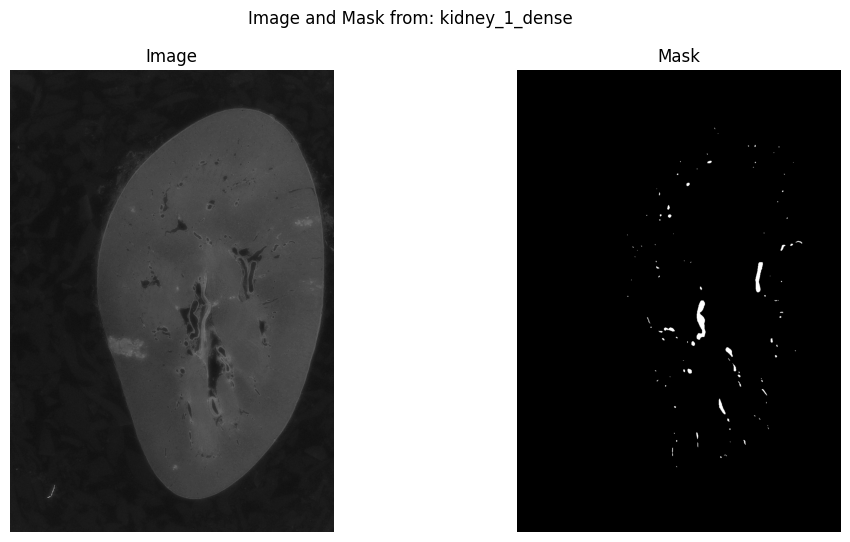

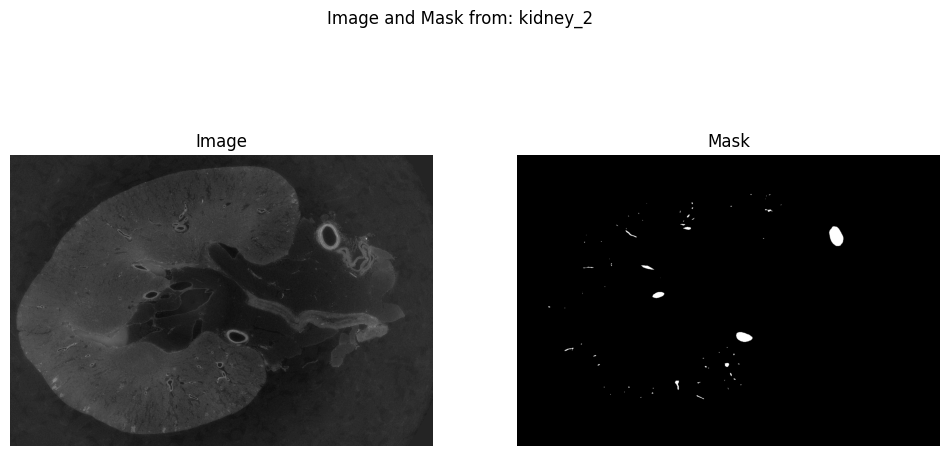

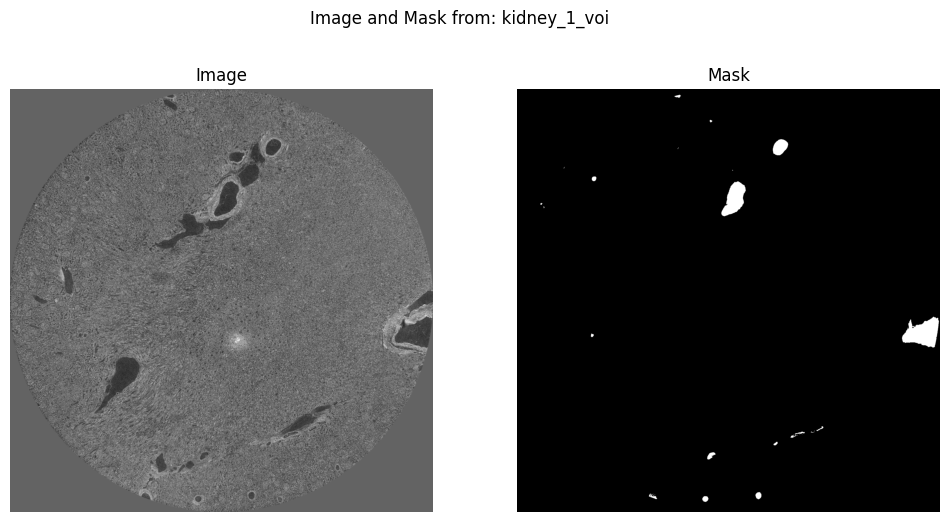

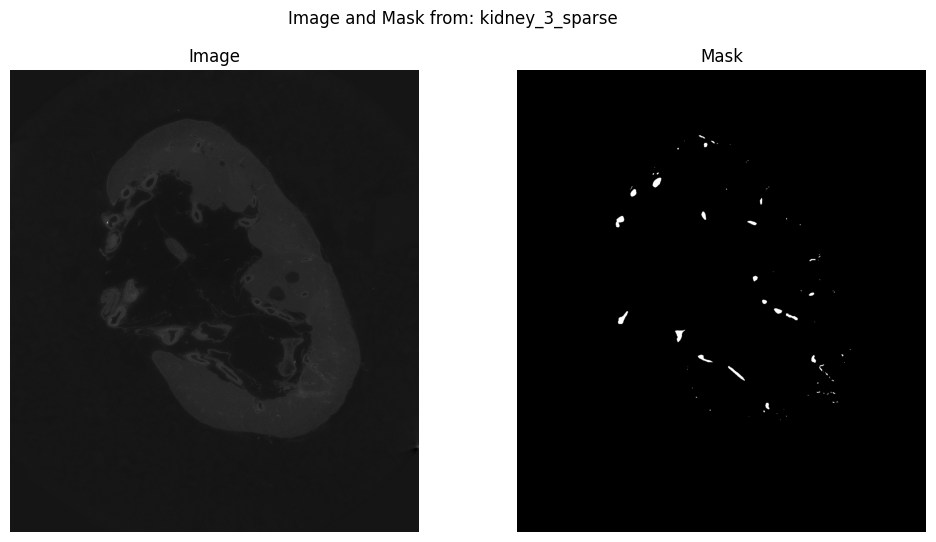

In [10]:
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread

def display_images_with_masks_from_paths(folders_info):
    """
    Displays a random image and its corresponding mask side by side, for each pair of image/label folders.

    Args:
    - folders_info (list): A list of paths for image and label directories.
    """
    # Splitting the provided info into image and label paths
    image_paths = [path for path in folders_info if "images" in path]
    label_paths = [path.replace("images", "labels") for path in image_paths]

    # Ensure pairing between images and labels is correct
    for img_path, lbl_path in zip(image_paths, label_paths):
        try:
            # Listing files and choosing a random image
            image_files = [f for f in os.listdir(img_path) if f.endswith('.tif')]
            if not image_files:
                print(f"No images found in {img_path}. Skipping...")
                continue

            random_image_name = random.choice(image_files)
            image_file_path = os.path.join(img_path, random_image_name)
            label_file_path = os.path.join(lbl_path, random_image_name)

            # Loading and displaying image and mask
            image = imread(image_file_path)
            label = imread(label_file_path)


            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image, cmap='gray')
            plt.title('Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(label, cmap='gray')
            plt.title('Mask')
            plt.axis('off')

            dataset_name = os.path.basename(os.path.dirname(img_path))
            plt.suptitle(f'Image and Mask from: {dataset_name}')
            plt.show()

        except FileNotFoundError as e:
            print(f"File not found: {e}")
        except Exception as e:
            print(f"Error loading image and mask: {e}")


display_images_with_masks_from_paths(train_folder_paths)


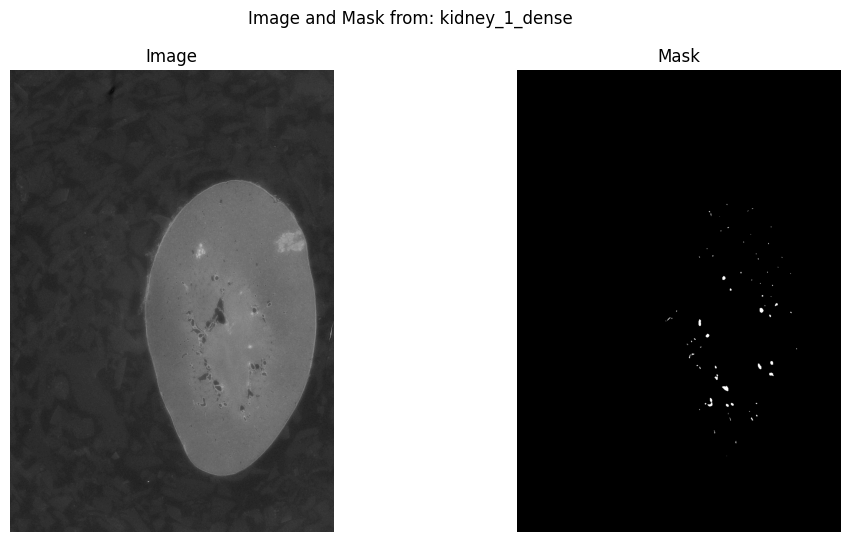

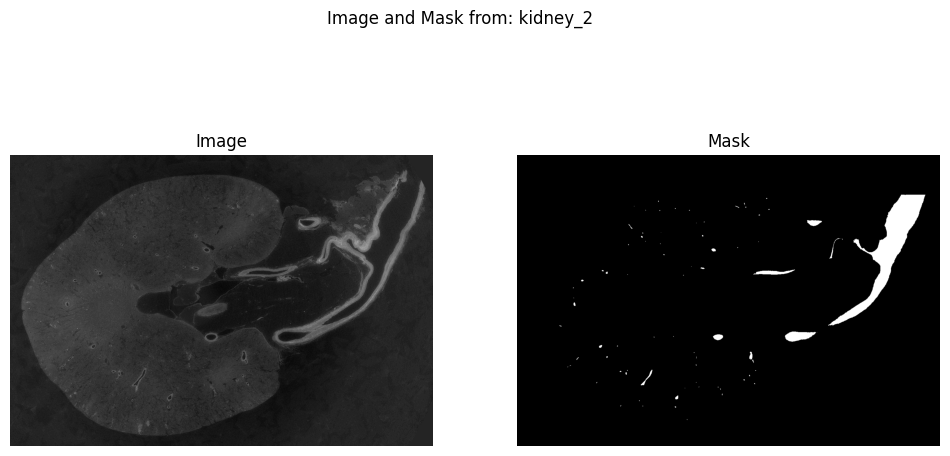

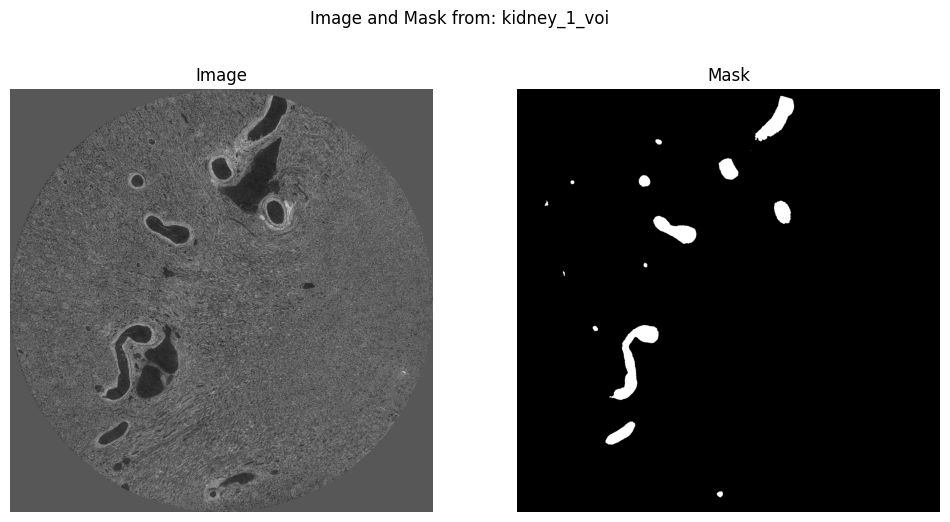

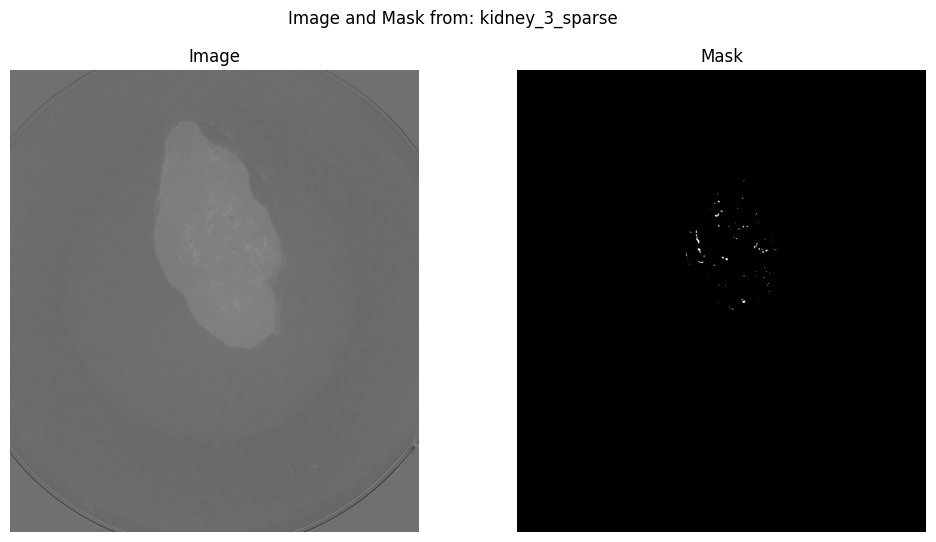

In [11]:
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread

def display_images_with_masks_from_paths(folders_info):
    """
    Displays a random image and its corresponding mask side by side, for each pair of image/label folders.

    Args:
    - folders_info (list): A list of paths for image and label directories.
    """
    # Splitting the provided info into image and label paths
    image_paths = [path for path in folders_info if "images" in path]
    label_paths = [path.replace("images", "labels") for path in image_paths]

    # Ensure pairing between images and labels is correct
    for img_path, lbl_path in zip(image_paths, label_paths):
        try:
            # Listing files and choosing a random image
            image_files = [f for f in os.listdir(img_path) if f.endswith('.tif')]
            if not image_files:
                print(f"No images found in {img_path}. Skipping...")
                continue

            random_image_name = random.choice(image_files)
            image_file_path = os.path.join(img_path, random_image_name)
            label_file_path = os.path.join(lbl_path, random_image_name)

            # Loading and displaying image and mask
            image = imread(image_file_path)
            label = imread(label_file_path)


            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(image, cmap='gray')
            plt.title('Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(label, cmap='gray')
            plt.title('Mask')
            plt.axis('off')

            dataset_name = os.path.basename(os.path.dirname(img_path))
            plt.suptitle(f'Image and Mask from: {dataset_name}')
            plt.show()

        except FileNotFoundError as e:
            print(f"File not found: {e}")
        except Exception as e:
            print(f"Error loading image and mask: {e}")


display_images_with_masks_from_paths(train_folder_paths)


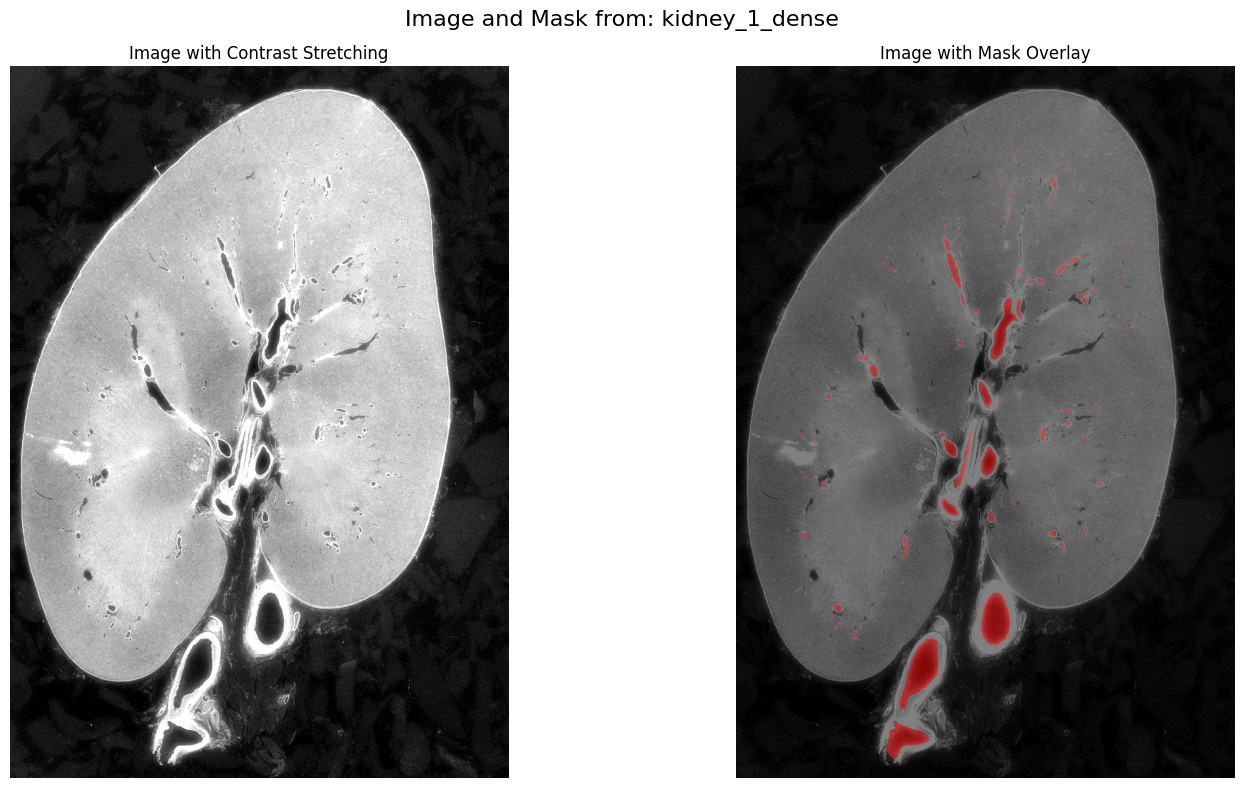

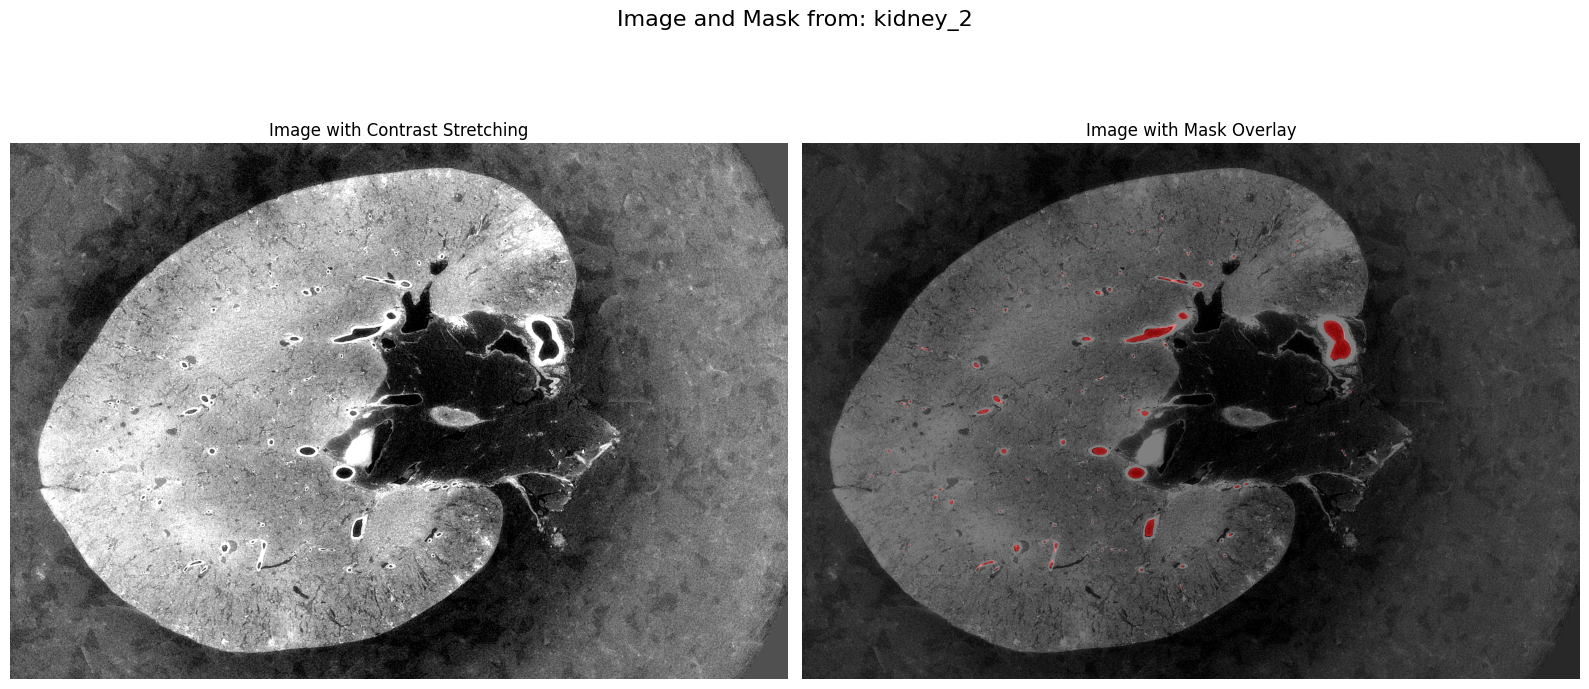

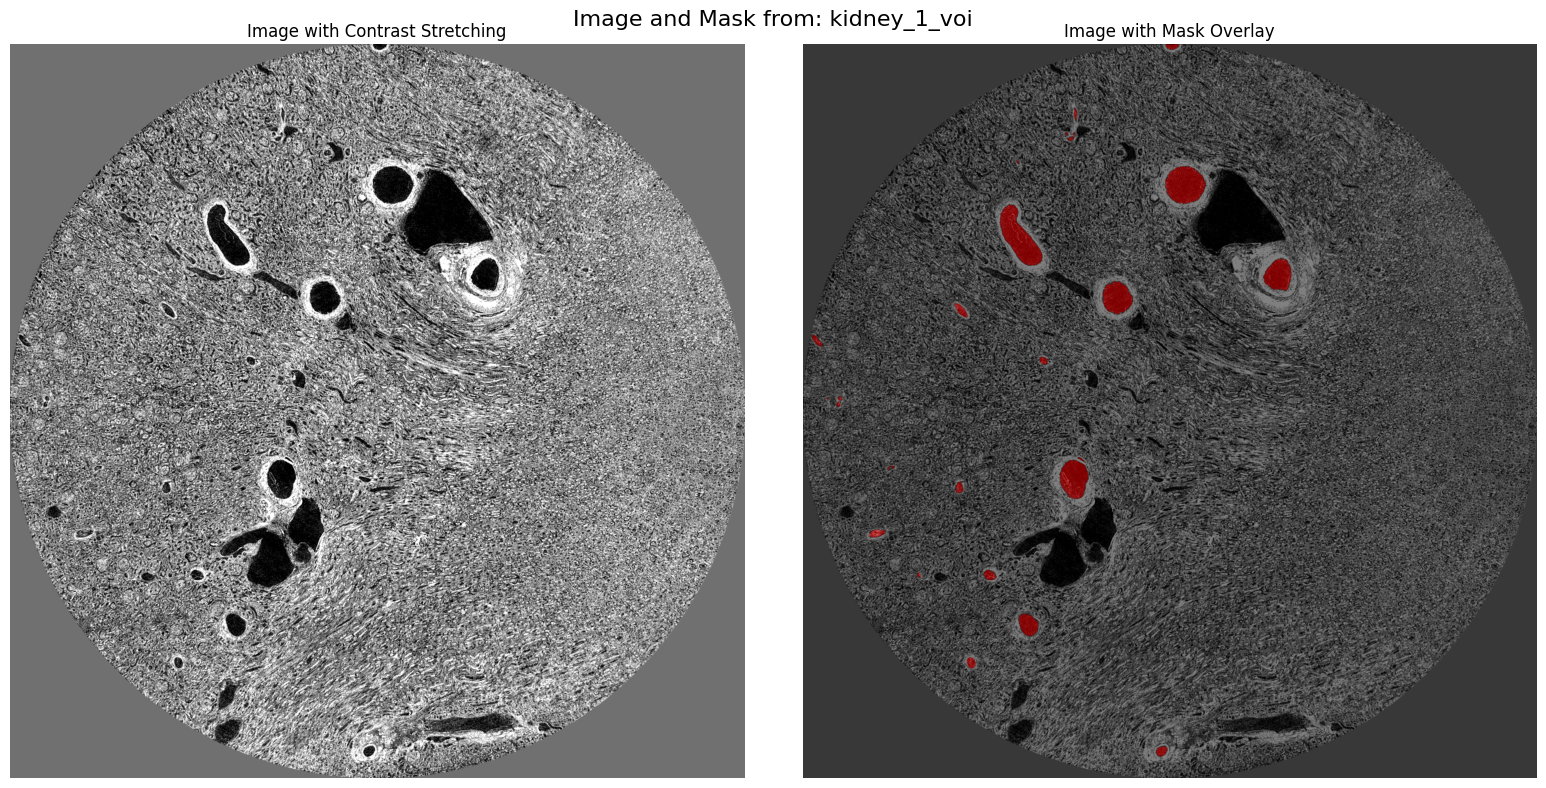

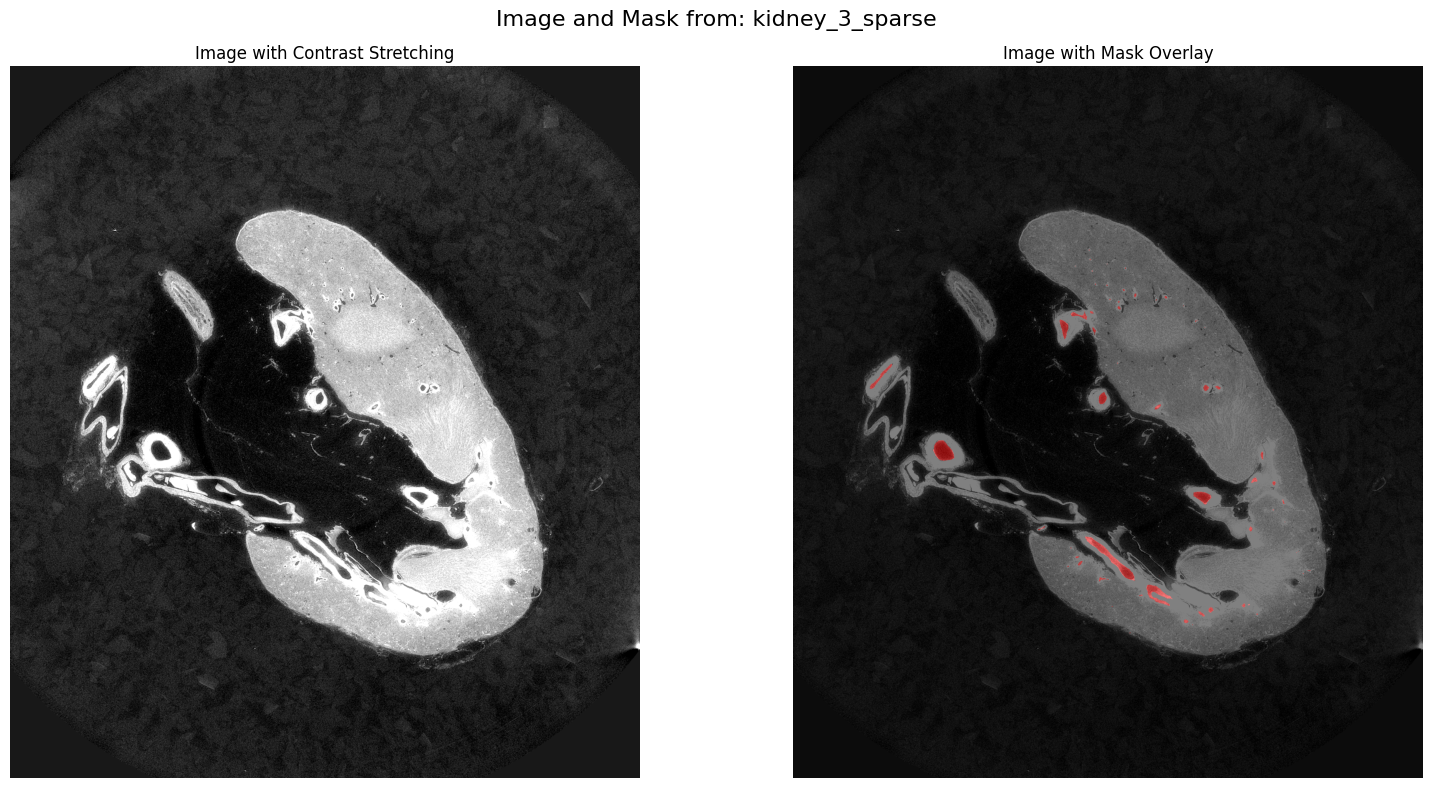

In [12]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure

def display_images_with_masks_from_paths(folders_info):
    """
    Displays a random image and its corresponding mask side by side, with contrast adjustment,
    for each pair of image/label folders.

    Args:
    - folders_info (list): A list of paths for image and label directories.
    """
    # Splitting the provided info into image and label paths
    image_paths = [path for path in folders_info if "images" in path]
    label_paths = [path.replace("images", "labels") for path in image_paths]

    # Ensure pairing between images and labels is correct
    for img_path, lbl_path in zip(image_paths, label_paths):
        try:
            # Listing files and choosing a random image
            image_files = [f for f in os.listdir(img_path) if f.endswith('.tif')]
            if not image_files:
                print(f"No images found in {img_path}. Skipping...")
                continue

            random_image_name = random.choice(image_files)
            image_file_path = os.path.join(img_path, random_image_name)
            label_file_path = os.path.join(lbl_path, random_image_name)

            # Loading image and mask
            image = imread(image_file_path)
            label = imread(label_file_path)

            # Adjust the image contrast using contrast stretching
            p2, p98 = np.percentile(image, (2, 98))
            image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

            # Create a boolean mask for the overlay
            mask_overlay = label.astype(bool)

            # Generate an RGB image for the overlay, red where the mask is True
            overlay_color = np.zeros((*mask_overlay.shape, 3))
            overlay_color[mask_overlay] = [1, 0, 0]  # Red color for the mask

            # Create a figure to display the results
            fig, ax = plt.subplots(1, 2, figsize=(16, 8))

            # Display the original image with adjusted contrast
            ax[0].imshow(image_rescale, cmap='gray')
            ax[0].set_title('Image with Contrast Stretching')
            ax[0].axis('off')

            # Overlay the red mask on the original image with some transparency
            ax[1].imshow(image_rescale, cmap='gray')
            ax[1].imshow(overlay_color, alpha=0.5)  # Overlay mask with half transparency
            ax[1].set_title('Image with Mask Overlay')
            ax[1].axis('off')

            # Set the title for the dataset
            dataset_name = os.path.basename(os.path.dirname(os.path.dirname(image_file_path)))
            fig.suptitle(f'Image and Mask from: {dataset_name}', fontsize=16)

            plt.tight_layout()
            plt.show()

        except FileNotFoundError as e:
            print(f"File not found: {e}")
        except Exception as e:
            print(f"Error loading image and mask: {e}")



display_images_with_masks_from_paths(train_folder_paths)


In [1]:
import os
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/se-net-pretrained-imagenet-weights/* /root/.cache/torch/hub/checkpoints/
import torch as tc 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
import os,sys,cv2
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt
import albumentations as A
!python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from glob import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Looking in links: /kaggle/input/pip-download-for-segmentation-models-pytorch
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/segmentation_models_pytorch-0.3.3-py3-none-any.whl
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/pretrainedmodels-0.7.4.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/efficientnet_pytorch-0.7.1.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/timm-0.9.2-py3-none-any.whl (from segmentation-models-pytorch)
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/munch-4.0.0-py2.py3-none-any.whl (from pretrainedmodels==0.7.4->segmentation-models-pytorch)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=93e7510e15089e6e0b47681208728ff9853fa

In [2]:
class Configuration:
    # Prediction Target Settings
    TARGET_SIZE = 1

    # Model Settings
    MODEL = {
        "name": 'Unet',
        "backbone": 'se_resnext50_32x4d',
        "input_channels": 5  # Originally 65
    }

    # Training Configuration
    IMAGE_SIZE = 512
    INPUT_SIZE = 512
    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 32  # Computed as train_batch_size * 2
    EPOCHS = 20
    LEARNING_RATE = 6e-5
    CHOPPING_PERCENTILE = 1e-3

    # Validation Fold
    VALID_ID = 1


    # Training Settings
    TRAINING = {
        "image_size": 512,
        "train_batch_size": 16,
        "valid_batch_size": 32,  # Computed as train_batch_size * 2
        "epochs": 20,
        "learning_rate": 6e-5,
        "chopping_percentile": 1e-3,
        "valid_fold_id": 1
    }

    # Augmentation Settings
    AUGMENTATION = {
        "train": A.Compose([
            A.Rotate(limit=45, p=0.5),
            A.RandomScale(scale_limit=(0.8, 1.25), interpolation=cv2.INTER_CUBIC, p=0.5),
            A.RandomCrop(512, 512, p=1),
            A.RandomGamma(p=0.75),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussianBlur(p=0.5),
            A.MotionBlur(p=0.5),
            A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
            ToTensorV2(transpose_mask=True),
        ]),
        "valid": A.Compose([
            ToTensorV2(transpose_mask=True),
        ])
    }


In [3]:
configuration = Configuration()

In [4]:
configuration.MODEL['backbone']

'se_resnext50_32x4d'

In [5]:
# import torch.nLEARNING_RATEn as nn
import segmentation_models_pytorch as smp

class CustomModel(nn.Module):
    def __init__(self, configuration, weight=None):
        super(CustomModel, self).__init__()
        # Initialize the Unet model with parameters from the configuration
        self.model = smp.Unet(
            encoder_name=configuration.MODEL['backbone'],
            encoder_weights=weight,
            in_channels=configuration.MODEL['input_channels'],
            classes=configuration.TARGET_SIZE,
            activation=None  # Linear activation on output
        )

    def forward(self, x):
        # Forward pass through the model
        output = self.model(x)
        # Reduce the last dimension if necessary and apply sigmoid activation
        return output[:, 0]  # Assuming binary segmentation with a single class output


def build_model(weight="imagenet"):
    from dotenv import load_dotenv
    load_dotenv()

    print('model_name', configuration.MODEL['name'])
    print('backbone', configuration.MODEL['backbone'])

    model = CustomModel(configuration, 'imagenet')

    return model.cuda()

In [7]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=810099ec1b010697b785dff61a43f6509b9a5651b24118bc5e01a1957815f704
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [9]:
pip install torchsummary


  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
from segmentation_models_pytorch import Unet
from torchsummary import summary

# Assuming your Configuration and CustomModel classes are defined as shown previously

# # Define the configuration object
# configuration = Configuration()

# # Instantiate the custom model
# model = CustomModel(configuration, weight='imagenet').to('cuda')

# Print the model summary
summary(model, input_size=(5, 512, 512))  # Adjust the input size according to your model's expected input


In [12]:
import torch
from torchviz import make_dot

# Assuming the Configuration and CustomModel classes are defined and imported as shown previously

# Instantiate the configuration and model
configuration = Configuration()
model = CustomModel(configuration, weight='imagenet').to('cuda')

# Create a dummy input appropriate for the input dimensions of your model
dummy_input = torch.randn(1, 5, 512, 512, device='cuda')

# Perform a forward pass to get the output
out = model(dummy_input)

# Simplify the graph by focusing on main components
def simplify_graph(graph, input_tensor):
    # Include the dummy input in the graph
    graph['input'] = input_tensor
    # Filter the graph to only include nodes of interest
    nodes_of_interest = ['Conv2d', 'BatchNorm2d', 'SEModule', 'ReLU', 'AdaptiveAvgPool2d', 'Unet']
    simplified_graph = {node: attr for node, attr in graph.items() if any(noi in node for noi in nodes_of_interest)}
    return simplified_graph

# Prepare the parameters dictionary
params_dict = dict(model.named_parameters())
params_dict.update({'input': dummy_input})

# Generate and render the graph using the simplified graph function
dot = make_dot(out, params=simplify_graph(params_dict, dummy_input))
dot.render('simplified_model_visualization', format='png')


'simplified_model_visualization.png'

In [8]:
import torch
from torchviz import make_dot

# Assuming the rest of your model and configuration setup as before

# Define the configuration object
configuration = Configuration()

# Instantiate the custom model
model = CustomModel(configuration, weight='imagenet').to('cuda')

# Create a dummy input tensor appropriate for the input dimensions of the model
dummy_input = torch.randn(1, 5, 512, 512, device='cuda')  # Adjust as necessary

# Perform a forward pass (necessary to trace the model)
out = model(dummy_input)

# Generate the graph
dot = make_dot(out, params=dict(list(model.named_parameters()) + [('input', dummy_input)]))
dot.render('custom_model_visualization', format='png')  # This saves the visualization to a file


'custom_model_visualization.png'

In [6]:
configuration

In [7]:
import torch as tc
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
from tqdm import tqdm
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch as tc
import numpy as np

class CustomModel(nn.Module):
    def __init__(self, configuration, weight=None):
        super(CustomModel, self).__init__()
        self.model = smp.Unet(
            encoder_name=configuration.MODEL['backbone'], 
            encoder_weights=weight,
            in_channels=configuration.MODEL['input_channels'],
            classes=configuration.TARGET_SIZE,
            activation=None
        )

    def forward(self, x):
        output = self.model(x)
        return output[:, 0]
# Correct usage of the Configuration class
# configuration = Configuration  # Make sure 'configuration' refers to the class itself, not a string or other type

# def build_model(configuration):
#     # Assuming 'CustomModel' and other functions are defined correctly
#     model = CustomModel(configuration)
#     return model.cuda() if tc.cuda.is_available() else model

# # Further down in your code
# model = build_model(configuration)  # Now passing the correct reference
# model = DataParallel(model)

def min_max_normalization(x: tc.Tensor) -> tc.Tensor:
    """Normalize the tensor along the last dimension if the tensor has more than two dimensions."""
    original_shape = x.shape
    if x.ndim > 2:
        x = x.reshape(x.shape[0], -1)
    min_val = x.min(dim=-1, keepdim=True)[0]
    max_val = x.max(dim=-1, keepdim=True)[0]
    if min_val.mean() == 0 and max_val.mean() == 1:
        return x.reshape(original_shape)
    x = (x - min_val) / (max_val - min_val + 1e-9)
    return x.reshape(original_shape)

def norm_with_clip(x: tc.Tensor, smooth=1e-5) -> tc.Tensor:
    """Normalize and clip the tensor values."""
    dims = list(range(1, x.ndim))
    mean = x.mean(dim=dims, keepdim=True)
    std = x.std(dim=dims, keepdim=True)
    x = (x - mean) / (std + smooth)
    x = tc.where(x > 5, (x - 5) * 1e-3 + 5, x)
    x = tc.where(x < -3, (x + 3) * 1e-3 - 3, x)
    return x

def add_noise(x: tc.Tensor, max_randn_rate=0.1, randn_rate=None, x_already_normed=False) -> tc.Tensor:
    """Add random noise to the tensor."""
    ndim = x.ndim - 1
    if x_already_normed:
        x_std = tc.ones([x.shape[0]] + [1] * ndim, device=x.device, dtype=x.dtype)
        x_mean = tc.zeros([x.shape[0]] + [1] * ndim, device=x.device, dtype=x.dtype)
    else:
        dim = list(range(1, x.ndim))
        x_std = x.std(dim=dim, keepdim=True)
        x_mean = x.mean(dim=dim, keepdim=True)
    if randn_rate is None:
        randn_rate = max_randn_rate * np.random.rand() * tc.rand(x_mean.shape, device=x.device, dtype=x.dtype)
    cache = (x_std**2 + (x_std * randn_rate)**2)**0.5
    return (x - x_mean + tc.randn(size=x.shape, device=x.device, dtype=x.dtype) * randn_rate * x_std) / (cache + 1e-7)

class Data_loader(Dataset):
    def __init__(self,paths,is_label):
        self.paths=paths
        self.paths.sort()
        self.is_label=is_label
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img=tc.from_numpy(img)
        if self.is_label:
            img=(img!=0).to(tc.uint8)*255
        else:
            img=img.to(tc.uint8)
        return img

def load_data(paths,is_label=False):
    data_loader=Data_loader(paths,is_label)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    del data
    if not is_label:
      
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * configuration.CHOPPING_PERCENTILE)
        TH:int = np.partition(TH, index)[index]
        x[x>TH]=int(TH)
      
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * configuration.CHOPPING_PERCENTILE)
        TH:int = np.partition(TH, -index)[-index]
        x[x<TH]=int(TH)
     
        x=(min_max_normalization(x.to(tc.float16)[None])[0]*255).to(tc.uint8)
    return x


def dice_coef(y_pred: tc.Tensor, y_true: tc.Tensor, threshold=0.5, dimensions=(-1, -2), epsilon=0.001) -> float:
    """Calculate the Dice coefficient for model validation."""
    y_pred = y_pred.sigmoid()
    y_true = y_true.to(tc.float32)
    y_pred = (y_pred > threshold).to(tc.float32)
    intersection = (y_true * y_pred).sum(dim=dimensions)
    denominator = y_true.sum(dim=dimensions) + y_pred.sum(dim=dimensions)
    dice = ((2 * intersection + epsilon) / (denominator + epsilon)).mean()
    return dice

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.sigmoid()
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

import numpy as np
import torch as tc

class KaggleDataset(Dataset):
    def __init__(self, x: list, y: list, augment=False, image_size=512, in_channels=5, transform=None):
        super(KaggleDataset, self).__init__()
        self.x = x  # List of tensors (C, H, W) for images
        self.y = y  # List of masks corresponding to the images
        self.image_size = image_size
        self.in_channels = in_channels
        self.augment = augment
        self.transform = transform

    def __len__(self) -> int:
        # Calculate the total number of valid slices based on input channels and image dimensions
        return sum(x.shape[0] - self.in_channels + 1 for x in self.x)

    def __getitem__(self, index: int):
        i = 0
        while index >= self.x[i].shape[0] - self.in_channels + 1:
            index -= self.x[i].shape[0] - self.in_channels + 1
            i += 1

        x = self.x[i]
        y = self.y[i]

        # Randomly select a starting point for cropping
        x_index = np.random.randint(0, x.shape[1] - self.image_size)
        y_index = np.random.randint(0, x.shape[2] - self.image_size)

        # Crop the images and masks according to calculated indices
        x_crop = x[index:index+self.in_channels, x_index:x_index+self.image_size, y_index:y_index+self.image_size]
        y_crop = y[index + self.in_channels // 2, x_index:x_index+self.image_size, y_index:y_index+self.image_size]

        # Apply transformations if provided
        if self.transform:
            transformed = self.transform(image=x_crop.numpy().transpose(1, 2, 0), mask=y_crop.numpy())
            x_crop = transformed['image']
            y_crop = transformed['mask']

        # Threshold mask
        y_crop = y_crop >= 127

        # Apply additional augmentations if specified
        if self.augment:
            rotations = np.random.randint(4)
            x_crop = tc.rot90(x_crop, rotations, [1, 2])
            y_crop = tc.rot90(y_crop, rotations, [0, 1])
            for axis in range(3):
                if np.random.rand() > 0.5:
                    x_crop = tc.flip(x_crop, [axis])
                    if axis >= 1:
                        y_crop = tc.flip(y_crop, [axis - 1])

        return x_crop, y_crop



In [8]:
train_x=[]
train_y=[]

root_path="/kaggle/input/blood-vessel-segmentation/"
parhs=["/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense"]
for i,path in enumerate(parhs):
    if path=="/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense":
        continue
    x=load_data(glob(f"{path}/images/*"),is_label=False)
    print(x.shape)
    y=load_data(glob(f"{path}/labels/*"),is_label=True)
    print(y.shape)
    train_x.append(x)
    train_y.append(y)

    #(C,H,W)

    #aug
    train_x.append(x.permute(1,2,0))
    train_y.append(y.permute(1,2,0))
    train_x.append(x.permute(2,0,1))
    train_y.append(y.permute(2,0,1))

100%|██████████| 143/143 [00:48<00:00,  2.97it/s]


torch.Size([2279, 1303, 912])


100%|██████████| 143/143 [00:26<00:00,  5.36it/s]


torch.Size([2279, 1303, 912])


In [9]:
path1="/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse"
path2="/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense"
paths_y=glob(f"{path2}/labels/*")
paths_x=[x.replace("labels","images").replace("dense","sparse") for x in paths_y]

val_x=load_data(paths_x,is_label=False)
print(val_x.shape)
val_y=load_data(paths_y,is_label=True)
print(val_y.shape)

100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


torch.Size([501, 1706, 1510])


100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


torch.Size([501, 1706, 1510])


In [10]:
import torch as tc
from torch.cuda.amp import GradScaler, autocast
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from tqdm import tqdm

# Enable CuDNN optimization for performance
tc.backends.cudnn.enabled = True
tc.backends.cudnn.benchmark = True

# Initialize datasets and dataloaders with settings from Configuration
train_dataset = KaggleDataset(train_x, train_y, augment=True)
train_loader = DataLoader(train_dataset, batch_size=configuration.TRAINING['train_batch_size'], num_workers=2, shuffle=True, pin_memory=True)

val_dataset = KaggleDataset([val_x], [val_y], augment=False)
val_loader = DataLoader(val_dataset, batch_size=configuration.TRAINING['valid_batch_size'], num_workers=2, shuffle=False, pin_memory=True)

# Build the model using the configuration specified
model = build_model(configuration.MODEL['backbone'])
model = DataParallel(model)

# Define loss function and optimizer
loss_func = DiceLoss()
optimizer = tc.optim.AdamW(model.parameters(), lr=configuration.TRAINING['learning_rate'])
scaler = GradScaler()
scheduler = tc.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=configuration.TRAINING['learning_rate'],
                                             steps_per_epoch=len(train_loader), epochs=configuration.TRAINING['epochs']+1,
                                             pct_start=0.1)

# Training loop
for epoch in range(configuration.TRAINING['epochs']):
    model.train()
    train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{configuration.TRAINING['epochs'] - 1}")
    train_loss, train_score = 0, 0

    for i, (x, y) in enumerate(train_tqdm):
        x, y = x.cuda().to(tc.float32), y.cuda().to(tc.float32)
        x = norm_with_clip(x.reshape(-1, *x.shape[2:])).reshape(x.shape)
        x = add_noise(x, max_randn_rate=0.5, x_already_normed=True)
        
        with autocast():
            pred = model(x)
            loss = loss_func(pred, y)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()

        score = dice_coef(pred.detach(), y)
        train_loss = (train_loss * i + loss.item()) / (i + 1)
        train_score = (train_score * i + score) / (i + 1)
        train_tqdm.set_postfix(loss=train_loss, score=train_score, lr=optimizer.param_groups[0]['lr'])

    # Validation loop
    model.eval()
    val_tqdm = tqdm(val_loader, desc="Validating")
    val_loss, val_score = 0, 0

    for i, (x, y) in enumerate(val_tqdm):
        x, y = x.cuda().to(tc.float32), y.cuda().to(tc.float32)
        x = norm_with_clip(x.reshape(-1, *x.shape[2:])).reshape(x.shape)

        with autocast(), tc.no_grad():
            pred = model(x)
            loss = loss_func(pred, y)
        
        score = dice_coef(pred.detach(), y)
        val_loss = (val_loss * i + loss.item()) / (i + 1)
        val_score = (val_score * i + score) / (i + 1)
        val_tqdm.set_postfix(loss=val_loss, score=val_score)

# Save model checkpoint
tc.save(model.module.state_dict(), f"./{configuration.MODEL['backbone']}_{epoch}_loss{train_loss:.2f}_score{train_score:.2f}_val_loss{val_loss:.2f}_val_score{val_score:.2f}.pt")


model_name Unet
backbone se_resnext50_32x4d


Validating: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s, loss=0.283, score=tensor(0.8005, device='cuda:0')]


In [8]:
import torch

In [9]:
class KaggleDataset(Dataset):
    def __init__(self, x: list, y: list, augment=False, image_size=512, in_channels=5, transform=None):
        super(KaggleDataset, self).__init__()
        self.x = x
        self.y = y
        self.image_size = image_size
        self.in_channels = in_channels
        self.augment = augment
        self.transform = transform

    def __len__(self):
        return sum(x.shape[0] - self.in_channels + 1 for x in self.x)

    def __getitem__(self, index):
        i = 0
        while index >= self.x[i].shape[0] - self.in_channels + 1:
            index -= self.x[i].shape[0] - self.in_channels + 1
            i += 1

        x = self.x[i]
        y = self.y[i]

        # Ensure that the image is large enough for cropping
        if x.shape[1] > self.image_size and x.shape[2] > self.image_size:
            x_index = np.random.randint(0, x.shape[1] - self.image_size)
            y_index = np.random.randint(0, x.shape[2] - self.image_size)
        else:
            x_index, y_index = 0, 0  # Default to no cropping if the image is too small

        x_crop = x[index:index + self.in_channels, x_index:x_index + self.image_size, y_index:y_index + self.image_size]
        y_crop = y[index + self.in_channels // 2, x_index:x_index + self.image_size, y_index:y_index + self.image_size]

        if self.transform:
            transformed = self.transform(image=x_crop.numpy().transpose(1, 2, 0), mask=y_crop.numpy())
            x_crop = transformed['image']
            y_crop = transformed['mask']

        y_crop = y_crop >= 127

        if self.augment:
            rotations = np.random.randint(4)
            x_crop = torch.rot90(x_crop, rotations, [1, 2])
            y_crop = torch.rot90(y_crop, rotations, [0, 1])
            for axis in range(3):
                if np.random.rand() > 0.5:
                    x_crop = torch.flip(x_crop, [axis])
                    if axis >= 1:
                        y_crop = torch.flip(y_crop, [axis - 1])

        return x_crop, y_crop


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import DataLoader
import numpy as np
import cv2
from glob import glob

from glob import glob

# Assuming CustomModel and Configuration are properly defined
configuration = Configuration()
def pad_to_multiple(image, multiple=32):
    """ Pad the image to ensure dimensions are divisible by the specified multiple. """
    height, width = image.shape[-2:]
    pad_height = (multiple - height % multiple) % multiple
    pad_width = (multiple - width % multiple) % multiple
    padding = (pad_width // 2, pad_width - pad_width // 2, pad_height // 2, pad_height - pad_height // 2)
    padded_image = F.pad(image, padding, mode='constant', value=0)
    return padded_image, padding

def unpad_from_multiple(padded_image, padding):
    """ Remove padding from the image. """
    left, right, top, bottom = padding
    height, width = padded_image.shape[-2:]
    return padded_image[..., top:height-bottom, left:width-right]

def load_model():
    model = CustomModel(configuration).cuda()  # Ensure the configuration is correctly initialized
    model_path = "/kaggle/input/my-se-resnext-model/se_resnext50_32x4d_19_loss0.05_score0.89_val_loss0.28_val_score0.80.pt"
    model.load_state_dict(torch.load(model_path, map_location='cuda'))
    model.eval()
    return model


# Assuming the KaggleDataset class has been defined as you provided

def load_and_process_images(paths, is_label=False):
    images = []
    for path in paths:
        # Load each image, convert to grayscale, resize, and append to the list
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (configuration.IMAGE_SIZE, configuration.IMAGE_SIZE))
        img = np.expand_dims(img, axis=0)  # Add channel dimension
        images.append(torch.tensor(img, dtype=torch.float32))
    return torch.stack(images)  # Stack to create a batch

# Load your validation data
val_image_paths = glob("/kaggle/input/blood-vessel-segmentation/train/kidney_2/images/*.tif")
val_label_paths = glob("/kaggle/input/blood-vessel-segmentation/train/kidney_2/labels/*.tif")  # Update as necessary

# Process the images and labels
val_images = load_and_process_images(val_image_paths)
val_labels = load_and_process_images(val_label_paths, is_label=True)

# Create the validation dataset
val_dataset = KaggleDataset(x=[val_images], y=[val_labels], augment=False)
val_loader = DataLoader(val_dataset, batch_size=configuration.VALID_BATCH_SIZE, shuffle=False)

In [37]:
def perform_inference(model, data_loader):
    model.eval()
    outputs = []
    for images, _ in data_loader:
        # Handle extra dimensions (if any)
        if images.dim() == 5 and images.size(2) == 1:
            images = images.squeeze(2)

        # Move images to GPU and ensure they are float
        images = images.to('cuda', dtype=torch.float)
        
        with torch.no_grad():
            preds = model(images)  # Forward pass
            preds = preds.sigmoid() > 0.5  # Apply sigmoid and threshold

        # Ensure there is a batch dimension
        if preds.dim() == 3:
            preds = preds.unsqueeze(1)  # Add a channel dimension if missing

        # Extract the middle slice from the batch of predictions if 3D
        if preds.dim() == 4:
            middle_index = preds.shape[1] // 2
            preds = preds[:, middle_index, :, :]  # Corrected index access

        outputs.append(preds.cpu())  # Move predictions to CPU

    return torch.cat(outputs, dim=0)  # Concatenate all batch outputs into a single tensor


def visualize_predictions(images, predictions):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    
    for i, (img, pred) in enumerate(zip(images, predictions)):
        img = img.squeeze()  # Ensure the image is 2D for display
        
        # Check if prediction tensor has an unexpected number of dimensions
        if pred.dim() > 2:
            pred = pred.squeeze(0)  # Remove the singleton dimension if it's present

        axs[i, 0].imshow(img, cmap='gray')
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(img, cmap='gray')
        axs[i, 1].imshow(pred, alpha=0.5, cmap='Reds')  # Red mask overlay
        axs[i, 1].set_title('Prediction Overlay')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


In [38]:
import torch
from torch.utils.data import DataLoader

def custom_collate(batch):
    """ Ensure that the data loader collates the batch elements into tensors """
    images, masks = zip(*batch)  # Assuming each element in the batch is a tuple (image, mask)
    images = torch.stack(images)  # Stack images to create a batch
    masks = torch.stack(masks)  # Stack masks to create a batch
    return images, masks

# Setup DataLoader with custom collate function
val_loader = DataLoader(val_dataset, batch_size=configuration.VALID_BATCH_SIZE, shuffle=False, collate_fn=custom_collate)

# Assuming the rest of the setup is correctly implemented
model = load_model()
predictions = perform_inference(model, val_loader)


In [40]:
predictions

tensor([[[ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False,  True, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]],

        [[ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False,  True, False],
         [ True,  True, False,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]],

        [[ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False,  True, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [ True, False,  True,  ...,  True,  True,  True],
         [

In [41]:
# Check and display the first few images and predictions
for img, pred in zip(sampled_images[:3], sampled_predictions[:3]):
    print("Image shape:", img.shape, "Prediction shape:", pred.shape)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.imshow(pred, alpha=0.5, cmap='Reds')  # Red mask overlay
    plt.title('Prediction Overlay')
    plt.axis('off')
    plt.show()


In [46]:
# Check a few images and predictions to make sure they contain valid data
print("Number of images:", len(sampled_images))
print("Number of predictions:", len(sampled_predictions))

for img, pred in zip(sampled_images[:3], sampled_predictions[:3]):
    print("Image shape:", img.shape, "Unique values:", torch.unique(img))
    print("Prediction shape:", pred.shape, "Unique values:", torch.unique(pred))


Number of images: 3
Number of predictions: 3
Image shape: torch.Size([512, 512]) Unique values: tensor([110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
        122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133.,
        134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145.,
        146., 147., 148., 149., 150., 151., 152., 153., 154., 155., 156., 157.,
        158., 159., 160., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
        170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180., 181.,
        182., 183., 184., 185., 186., 187., 188., 189., 190., 191., 192., 193.,
        194., 195., 196., 197., 198., 200., 201., 202.])
Prediction shape: torch.Size([512, 512]) Unique values: tensor([False,  True])
Image shape: torch.Size([512, 512]) Unique values: tensor([103., 104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
        115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126

In [ ]:
# import matplotlib.pyplot as plt

# # Sample a small subset of images and predictions for visualization
# sampled_images = [img.squeeze() for img in val_images[:3]]  # Adjust as needed, remove batch or channel dimension if present
# sampled_predictions = predictions[:3]

# def visualize_predictions(images, predictions):
#     num_images = len(images)
#     fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    
#     for i, (img, pred) in enumerate(zip(images, predictions)):
#         if pred.dim() > 2:
#             pred = pred.squeeze()  # Reduce to 2D if necessary
        
#         axs[i, 0].imshow(img, cmap='gray')
#         axs[i, 0].set_title('Original Image')
#         axs[i, 0].axis('off')

#         axs[i, 1].imshow(img, cmap='gray')
#         axs[i, 1].imshow(pred, alpha=0.5, cmap='Reds')  # Red mask overlay
#         axs[i, 1].set_title('Prediction Overlay')
#         axs[i, 1].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Ensure you've transformed predictions correctly before visualizing
# if len(sampled_predictions) > 0 and sampled_predictions[0].dim() > 2:
#     sampled_predictions = [p.squeeze() for p in sampled_predictions]  # Adjust the dimensions if necessary

# visualize_predictions(sampled_images, sampled_predictions)


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def visualize_predictions(images, predictions):
#     num_images = len(images)
#     fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    
#     for i, (img, pred) in enumerate(zip(images, predictions)):
#         if pred.dim() > 2:
#             pred = pred.squeeze()  # Reduce to 2D if necessary
        
#         # Original image
#         axs[i, 0].imshow(img, cmap='gray')
#         axs[i, 0].set_title('Original Image')
#         axs[i, 0].axis('off')

#         # Prediction overlay
#         # Create an RGB version of the gray image
#         colored_img = np.stack([img]*3, axis=-1)
        
#         # Create a red mask where the prediction is True
#         red_mask = np.zeros_like(colored_img)
#         red_mask[:, :, 0] = 255  # Red channel
#         red_mask[pred == 0] = colored_img[pred == 0]  # Apply original image where prediction is False
        
#         axs[i, 1].imshow(red_mask)
#         axs[i, 1].set_title('Prediction Overlay')
#         axs[i, 1].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Assuming 'sampled_images' and 'sampled_predictions' are already defined
# visualize_predictions(sampled_images, sampled_predictions)


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def visualize_predictions(images, predictions):
#     num_images = len(images)
#     fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    
#     for i, (img, pred) in enumerate(zip(images, predictions)):
#         if pred.dim() > 2:
#             pred = pred.squeeze()  # Reduce to 2D if necessary
        
#         axs[i, 0].imshow(img, cmap='gray')
#         axs[i, 0].set_title('Original Image')
#         axs[i, 0].axis('off')

#         # Create an RGB version of the gray image for overlay purposes
#         colored_img = np.stack([img]*3, axis=-1).astype(np.uint8)
        
#         # Create a red mask overlay where the prediction is False
#         red_mask = np.zeros_like(colored_img)
#         red_mask[:, :, 0] = 255  # Set the red channel

#         # Use the prediction to set the mask
#         mask = pred == 0  # Places where prediction is False
#         overlay = colored_img.copy()
#         overlay[mask] = red_mask[mask]  # Apply red where the mask is True (prediction is False)

#         axs[i, 1].imshow(overlay)
#         axs[i, 1].set_title('Prediction Overlay')
#         axs[i, 1].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Assuming 'sampled_images' and 'sampled_predictions' are already defined
# visualize_predictions(sampled_images, sampled_predictions)


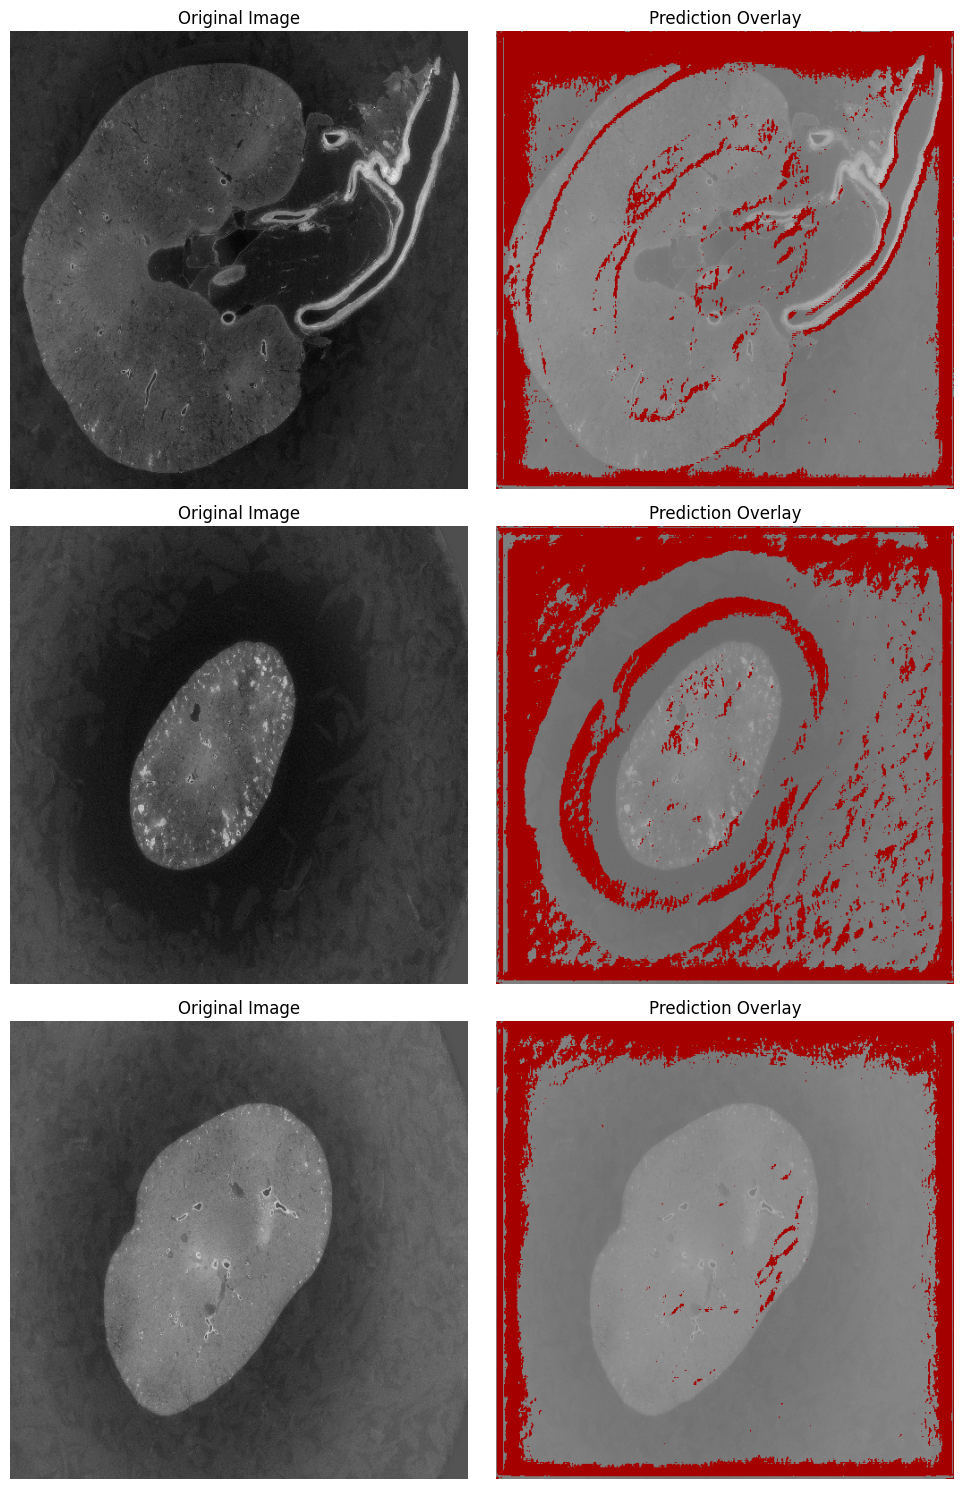

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(images, predictions, threshold=0.5):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    
    for i, (img, pred) in enumerate(zip(images, predictions)):
        if pred.dim() > 2:
            pred = pred.squeeze()  # Reduce to 2D if necessary
        
        axs[i, 0].imshow(img, cmap='gray')
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        # Apply the threshold to prediction
        thresholded_pred = pred > threshold
        
        # Create an RGB version of the gray image for overlay purposes
        colored_img = np.stack([img]*3, axis=-1).astype(np.uint8)
        
        # Create a red mask overlay where the prediction is False
        red_mask = np.zeros_like(colored_img)
        red_mask[:, :, 0] = 165 # Set the red channel

        # Use the thresholded prediction to set the mask
        mask = ~thresholded_pred  # Places where prediction is below threshold
        overlay = colored_img.copy()
        overlay[mask] = red_mask[mask]  # Apply red where the mask is True (prediction is below threshold)

        axs[i, 1].imshow(overlay)
        axs[i, 1].set_title('Prediction Overlay')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# You can now call visualize_predictions with a different threshold:
visualize_predictions(sampled_images, sampled_predictions, threshold=0.05)  # Adjust threshold as needed


In [2]:
!pip install streamlit

  Obtaining dependency information for streamlit from https://files.pythonhosted.org/packages/c6/51/f140402202af6ce1bf747243f66415c5eb2f43ba2e2ac419a7e855d20673/streamlit-1.36.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pydeck<1,>=0.8.0b4 from https://files.pythonhosted.org/packages/ab/4c/b888e6cf58bd9db9c93f40d1c6be8283ff49d88919231afe93a6bcf61626/pydeck-0.9.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for watchdog<5,>=2.1.5 from https://files.pythonhosted.org/packages/24/01/a4034a94a5f1828eb050230e7cf13af3ac23cf763512b6afe008d3def97c/watchdog-4.0.1-py3-none-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 26.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.7 MB/s eta 0:00:00


In [3]:
!pip install pyngrok
from pyngrok import ngrok

  Obtaining dependency information for pyngrok from https://files.pythonhosted.org/packages/cb/55/68b89d526e8331724665dcded0a32a76d73d6bcac41cc56084fda8e25486/pyngrok-7.1.6-py3-none-any.whl.metadata


In [4]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

class Configuration:
    # Prediction Target Settings
    TARGET_SIZE = 1

    # Model Settings
    MODEL = {
        "name": 'Unet',
        "backbone": 'se_resnext50_32x4d',
        "input_channels": 5
    }

    # Training Configuration
    IMAGE_SIZE = 512
    INPUT_SIZE = 512

class CustomModel(nn.Module):
    def __init__(self, configuration):
        super(CustomModel, self).__init__()
        self.model = smp.Unet(
            encoder_name=configuration.MODEL['backbone'],
            encoder_weights=None,
            in_channels=configuration.MODEL['input_channels'],
            classes=configuration.TARGET_SIZE,
            activation=None
        )

    def forward(self, x):
        return self.model(x)

@st.cache_resource
def load_model():
    configuration = Configuration()
    model = CustomModel(configuration)
    model_path = "/kaggle/input/my-se-resnext-model/se_resnext50_32x4d_19_loss0.05_score0.89_val_loss0.28_val_score0.80.pt"
    model.load_state_dict(torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))
    model.eval()
    return model

def process_image(img):
    img_array = np.array(img)
    
    # Convert to float32 and normalize
    img_array = img_array.astype(np.float32) / np.max(img_array)
    
    if len(img_array.shape) == 2 or (len(img_array.shape) == 3 and img_array.shape[2] == 1):
        img_gray = img_array
    else:
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    img_resized = cv2.resize(img_gray, (512, 512))
    img_final = np.expand_dims(img_resized, axis=(0, 1))
    
    return torch.tensor(img_final, dtype=torch.float32)


def perform_inference(model, images):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    images = images.to(device)
    with torch.no_grad():
        preds = model(images)
    preds = torch.sigmoid(preds)
    return (preds > 0.5).cpu().squeeze()

def visualize_prediction(image, prediction):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.squeeze(), cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(image.squeeze(), cmap='gray')
    ax2.imshow(prediction, alpha=0.5, cmap='Reds')
    ax2.set_title('Prediction Overlay')
    ax2.axis('off')
    return fig

st.title('Blood Vessel Segmentation App')

uploaded_files = st.file_uploader("Upload 5 consecutive image slices", type=["png", "jpg", "jpeg", 'tif'], accept_multiple_files=True)

if uploaded_files and len(uploaded_files) == 5:
    images = torch.cat([process_image(Image.open(file)) for file in uploaded_files], dim=1)
    
    model = load_model()
    predictions = perform_inference(model, images)
    
    slice_index = st.slider("Select which slice to visualize", 0, 4, 2)
    
    fig = visualize_prediction(images[:, slice_index], predictions[slice_index])
    st.pyplot(fig)
else:
    st.warning("Please upload exactly 5 image slices.")

Writing app.py


In [5]:
!ngrok config add-authtoken 2VJXf1SjlcpG5WPLyrgDcEaM2ct_7KytqnABitp5VfqfxZCYf

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml                                


In [6]:
!wget -q -O - ipv4.icanhazip.com

35.239.208.190


In [7]:
!npm install -g localtunnel

m#################⠂) ⠧ reify:yargs-parser: http fetch GET 200 https://registry.
added 22 packages in 2s

3 packages are looking for funding
  run `npm fund` for details
npm notice 
npm notice New major version of npm available! 9.8.0 -> 10.8.1
npm notice Changelog: https://github.com/npm/cli/releases/tag/v10.8.1
npm notice Run npm install -g npm@10.8.1 to update!
npm notice 


In [9]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.19.2.2:8501
  External URL: http://35.239.208.190:8501

your url is: https://pretty-symbols-arrive.loca.lt
2024-07-01 02:34:47.652 Uncaught app exception
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 589, in _run_script
    exec(code, module.__dict__)
  File "/kaggle/working/app.py", line 85, in <module>
    images = torch.cat([process_image(Image.open(file)) for file in uploaded_files], dim=1)
  File "/kaggle/working/app.py", line 85, in <listcomp>
    images = torch.cat([process_image(Image.open(file)) for file in uploaded_files], dim=1)
  File "/kaggle/working/app.py", line 57, in process_image
    return torch.tensor(img_final, dtype=torch.float32)
TypeError: can't convert np.ndarray of type numpy.uint16. The only supported types are: float64, float32, float16, complex64, c

In [43]:
import matplotlib.pyplot as plt

# Sample a small subset of images and predictions for visualization if necessary
sampled_images = val_images[:10]  # Adjust number as needed
sampled_predictions = predictions[:10]

# # Ensure the predictions are in the right shape for visualization
# # This is necessary because your predictions should match the visualization requirements (2D for imshow)
# sampled_predictions = [p.squeeze() for p in sampled_predictions if p.dim() > 2]

# # Call the visualization function
# try:
#     visualize_predictions(sampled_images, sampled_predictions)
# except Exception as e:
#     print("Error during visualization:", str(e))


In [12]:
import torch
from torch.utils.data import DataLoader

def custom_collate(batch):
    """ Ensure that the data loader collates the batch elements into tensors """
    images, masks = zip(*batch)  # Assuming each element in the batch is a tuple (image, mask)
    images = torch.stack(images)  # Stack images to create a batch
    masks = torch.stack(masks)  # Stack masks to create a batch
    return images, masks

# Setup DataLoader with custom collate function
val_loader = DataLoader(val_dataset, batch_size=configuration.VALID_BATCH_SIZE, shuffle=False, collate_fn=custom_collate)

# Assuming the rest of the setup is correctly implemented
model = load_model()
predictions = perform_inference(model, val_loader)


Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into the model: torch.Size([32, 5, 512, 512])
Tensor shape going into t

In [ ]:
def check_loader_shapes(data_loader):
    for i, data in enumerate(data_loader):
        if isinstance(data, tuple):
            # Assuming data contains images and possibly labels
            images = data[0]  # Modify if your data structure differs
            print(f"Batch {i + 1}: Images shape = {images.shape}")
            if len(data) > 1:
                labels = data[1]
                print(f"Batch {i + 1}: Labels shape = {labels.shape}")
        else:
            # If the loader directly returns images
            print(f"Batch {i + 1}: Images shape = {data.shape}")

# Assuming val_loader is already defined and loaded
check_loader_shapes(val_loader)


In [31]:
import matplotlib.pyplot as plt

def visualize_predictions(images, predictions):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    
    for i, (img, pred) in enumerate(zip(images, predictions)):
        axs[i][0].imshow(img, cmap='gray')
        axs[i][0].axis('off')

        axs[i][1].imshow(img, cmap='gray')
        axs[i][1].imshow(pred, alpha=0.5, cmap='Reds')  # Red mask overlay
        axs[i][1].axis('off')

    plt.tight_layout()
    plt.show()

# # Sample a small subset of images and predictions for visualization
# sampled_images = val_images[:5]  # Sample a few images for visualization
# sampled_predictions = predictions[:5]  # Corresponding predictions
# visualize_predictions(sampled_images, sampled_predictions)


In [ ]:
def perform_inference(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    outputs = []
    for images, _ in data_loader:  # Unpack the tuple (assuming labels are not needed for inference)
        images = images.to('cuda', dtype=torch.float32)  # Ensure images are on GPU and are of type float32

        with torch.no_grad():  # No need to compute gradients
            preds = model(images)  # Forward pass
            preds = preds.sigmoid() > 0.5  # Apply sigmoid and threshold to get binary mask

        outputs.append(preds.cpu())  # Move predictions to CPU

    return torch.cat(outputs, dim=0)  # Concatenate all batch outputs into a single tensor

# Assuming your model and data loader ('val_loader') are properly set up
model = load_model()  # Load the model
predictions = perform_inference(model, val_loader)  # Perform inference

# Now, you can visualize the predictions
# Assuming `val_images` is a list of the original image tensors
# Convert them back to numpy for visualization if necessary
visualized_images = [img.numpy().squeeze() for img, _ in val_dataset]  # Get images from dataset for visualization
visualize_predictions(visualized_images, [p.numpy() for p in predictions])  # Convert tensors to numpy for plotting


In [24]:
def visualize_predictions(images, predictions):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    if num_images == 1:  # If only one image, axs might not have a second dimension
        axs = [axs]
    
    for i, (img, pred) in enumerate(zip(images, predictions)):
        if pred.ndim == 3:  # If prediction has an unexpected number of dimensions
            pred = pred.squeeze(0)  # Attempt to correct it
        axs[i][0].imshow(img, cmap='gray')
        axs[i][0].axis('off')

        axs[i][1].imshow(img, cmap='gray')
        axs[i][1].imshow(pred, alpha=0.5, cmap='Reds')  # Red mask overlay
        axs[i][1].axis('off')

    plt.tight_layout()
    plt.show()


In [20]:
# def visualize_predictions(images, predictions):
#     fig, axs = plt.subplots(len(images), 2, figsize=(10, 5 * len(images)))
#     for i, (img, pred) in enumerate(zip(images, predictions)):
#         img = img.squeeze()
#         pred = pred.squeeze()
#         axs[i, 0].imshow(img, cmap='gray')
#         axs[i, 0].set_title('Original Image')
#         axs[i, 0].axis('off')

#         axs[i, 1].imshow(img, cmap='gray')
#         axs[i, 1].imshow(pred, alpha=0.5, cmap='Reds')  # Red mask overlay
#         axs[i, 1].set_title('Prediction Overlay')
#         axs[i, 1].axis('off')

#     plt.tight_layout()
#     plt.show()

In [25]:
# Sample a small subset of images and predictions for visualization
sampled_images = val_images[:3]  # Adjust number as needed
sampled_predictions = predictions2[:3]

In [26]:
# Modify this part if needed to adjust shapes
predictions2 = [p.squeeze() for p in predictions]  # Ensure each prediction is 2D


In [ ]:
import torch as tc
from torch.cuda.amp import GradScaler, autocast
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from tqdm import tqdm

# Enable CuDNN optimization for performance
tc.backends.cudnn.enabled = True
tc.backends.cudnn.benchmark = True

# Initialize datasets and dataloaders with settings from Configuration
train_dataset = KaggleDataset(train_x, train_y, augment=True)
train_loader = DataLoader(train_dataset, batch_size=configuration.TRAINING['train_batch_size'], num_workers=2, shuffle=True, pin_memory=True)

val_dataset = KaggleDataset([val_x], [val_y], augment=False)
val_loader = DataLoader(val_dataset, batch_size=configuration.TRAINING['valid_batch_size'], num_workers=2, shuffle=False, pin_memory=True)

# Build the model using the configuration specified
model = build_model(configuration.MODEL['backbone'])
model = DataParallel(model)

# Define loss function and optimizer
loss_func = DiceLoss()
optimizer = tc.optim.AdamW(model.parameters(), lr=configuration.TRAINING['learning_rate'])
scaler = GradScaler()
scheduler = tc.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=configuration.TRAINING['learning_rate'],
                                             steps_per_epoch=len(train_loader), epochs=configuration.TRAINING['epochs']+1,
                                             pct_start=0.1)

# Training loop
for epoch in range(configuration.TRAINING['epochs']):
    model.train()
    train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{configuration.TRAINING['epochs'] - 1}")
    train_loss, train_score = 0, 0

    for i, (x, y) in enumerate(train_tqdm):
        x, y = x.cuda().to(tc.float32), y.cuda().to(tc.float32)
        x = norm_with_clip(x.reshape(-1, *x.shape[2:])).reshape(x.shape)
        x = add_noise(x, max_randn_rate=0.5, x_already_normed=True)
        
        with autocast():
            pred = model(x)
            loss = loss_func(pred, y)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()

        score = dice_coef(pred.detach(), y)
        train_loss = (train_loss * i + loss.item()) / (i + 1)
        train_score = (train_score * i + score) / (i + 1)
        train_tqdm.set_postfix(loss=train_loss, score=train_score, lr=optimizer.param_groups[0]['lr'])

    # Validation loop
    model.eval()
    val_tqdm = tqdm(val_loader, desc="Validating")
    val_loss, val_score = 0, 0

    for i, (x, y) in enumerate(val_tqdm):
        x, y = x.cuda().to(tc.float32), y.cuda().to(tc.float32)
        x = norm_with_clip(x.reshape(-1, *x.shape[2:])).reshape(x.shape)

        with autocast(), tc.no_grad():
            pred = model(x)
            loss = loss_func(pred, y)
        
        score = dice_coef(pred.detach(), y)
        val_loss = (val_loss * i + loss.item()) / (i + 1)
        val_score = (val_score * i + score) / (i + 1)
        val_tqdm.set_postfix(loss=val_loss, score=val_score)

# Save model checkpoint
tc.save(model.module.state_dict(), f"./{configuration.MODEL['backbone']}_{epoch}_loss{train_loss:.2f}_score{train_score:.2f}_val_loss{val_loss:.2f}_val_score{val_score:.2f}.pt")


model_name Unet
backbone se_resnext50_32x4d


Epoch 7/19:  84%|████████▍ | 236/281 [01:40<00:19,  2.36it/s, loss=0.0759, lr=4.73e-5, score=tensor(0.8667, device='cuda:0')]

In [17]:
configuration.MODEL

{'name': 'Unet', 'backbone': 'se_resnext50_32x4d', 'input_channels': 5}

# Import

# config

In [ ]:
class CFG:
    # ============== pred target =============
    target_size = 1

    # ============== model CFG =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'

    in_chans = 5 # 65
    # ============== training CFG =============
    image_size = 512
    input_size=512

    train_batch_size = 16
    valid_batch_size = train_batch_size * 2

    epochs = 20
    lr = 6e-5
    chopping_percentile=1e-3
    # ============== fold =============
    valid_id = 1


    # ============== augmentation =============
    train_aug_list = [
        A.Rotate(limit=45, p=0.5),
        A.RandomScale(scale_limit=(0.8,1.25),interpolation=cv2.INTER_CUBIC,p=0.5),
        A.RandomCrop(input_size, input_size,p=1),
        A.RandomGamma(p=0.75),
        A.RandomBrightnessContrast(p=0.5,),
        A.GaussianBlur(p=0.5),
        A.MotionBlur(p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        ToTensorV2(transpose_mask=True),
    ]
    train_aug = A.Compose(train_aug_list)
    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]
    valid_aug = A.Compose(valid_aug_list)

# Model

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.model(image)
        # output = output.squeeze(-1)
        return output[:,0]#.sigmoid()


def build_model(weight="imagenet"):
    from dotenv import load_dotenv
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()

# Functions

In [ ]:
def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:tc.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

def add_noise(x:tc.Tensor,max_randn_rate=0.1,randn_rate=None,x_already_normed=False):
    """input.shape=(batch,f1,f2,...) output's var will be normalizate  """
    ndim=x.ndim-1
    if x_already_normed:
        x_std=tc.ones([x.shape[0]]+[1]*ndim,device=x.device,dtype=x.dtype)
        x_mean=tc.zeros([x.shape[0]]+[1]*ndim,device=x.device,dtype=x.dtype)
    else: 
        dim=list(range(1,x.ndim))
        x_std=x.std(dim=dim,keepdim=True)
        x_mean=x.mean(dim=dim,keepdim=True)
    if randn_rate is None:
        randn_rate=max_randn_rate*np.random.rand()*tc.rand(x_mean.shape,device=x.device,dtype=x.dtype)
    cache=(x_std**2+(x_std*randn_rate)**2)**0.5
    #https://blog.csdn.net/chaosir1991/article/details/106960408
    
    return (x-x_mean+tc.randn(size=x.shape,device=x.device,dtype=x.dtype)*randn_rate*x_std)/(cache+1e-7)

class Data_loader(Dataset):
    def __init__(self,paths,is_label):
        self.paths=paths
        self.paths.sort()
        self.is_label=is_label
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img=tc.from_numpy(img)
        if self.is_label:
            img=(img!=0).to(tc.uint8)*255
        else:
            img=img.to(tc.uint8)
        return img

def load_data(paths,is_label=False):
    data_loader=Data_loader(paths,is_label)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    del data
    if not is_label:
        ########################################################################
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * CFG.chopping_percentile)
        TH:int = np.partition(TH, index)[index]
        x[x>TH]=int(TH)
        ########################################################################
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * CFG.chopping_percentile)
        TH:int = np.partition(TH, -index)[-index]
        x[x<TH]=int(TH)
        ########################################################################
        x=(min_max_normalization(x.to(tc.float16)[None])[0]*255).to(tc.uint8)
    return x


#https://www.kaggle.com/code/kashiwaba/sennet-hoa-train-unet-simple-baseline
def dice_coef(y_pred:tc.Tensor,y_true:tc.Tensor, thr=0.5, dim=(-1,-2), epsilon=0.001):
    y_pred=y_pred.sigmoid()
    y_true = y_true.to(tc.float32)
    y_pred = (y_pred>thr).to(tc.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean()
    return dice

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = inputs.sigmoid()   
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class Kaggld_Dataset(Dataset):
    def __init__(self,x:list,y:list,arg=False):
        super(Dataset,self).__init__()
        self.x=x#list[(C,H,W),...]
        self.y=y#list[(C,H,W),...]
        self.image_size=CFG.image_size
        self.in_chans=CFG.in_chans
        self.arg=arg
        if arg:
            self.transform=CFG.train_aug
        else: 
            self.transform=CFG.valid_aug

    def __len__(self) -> int:
        return sum([y.shape[0]-self.in_chans for y in self.y])
    
    def __getitem__(self,index):
        i=0
        for x in self.x:
            if index>x.shape[0]-self.in_chans:
                index-=x.shape[0]-self.in_chans
                i+=1
            else:
                break
        x=self.x[i]
        y=self.y[i]
        
        x_index=np.random.randint(0,x.shape[1]-self.image_size)
        y_index=np.random.randint(0,x.shape[2]-self.image_size)

        x=x[index:index+self.in_chans,x_index:x_index+self.image_size,y_index:y_index+self.image_size]
        y=y[index+self.in_chans//2,x_index:x_index+self.image_size,y_index:y_index+self.image_size]

        data = self.transform(image=x.numpy().transpose(1,2,0), mask=y.numpy())
        x = data['image']
        y = data['mask']>=127
        if self.arg:
            i=np.random.randint(4)
            x=x.rot90(i,dims=(1,2))
            y=y.rot90(i,dims=(0,1))
            for i in range(3):
                if np.random.randint(2):
                    x=x.flip(dims=(i,))
                    if i>=1:
                        y=y.flip(dims=(i-1,))
        return x,y#(uint8,uint8)


# Load data 

In [ ]:
train_x=[]
train_y=[]

root_path="/kaggle/input/blood-vessel-segmentation/"
parhs=["/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense"]
for i,path in enumerate(parhs):
    if path=="/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense":
        continue
    x=load_data(glob(f"{path}/images/*"),is_label=False)
    print(x.shape)
    y=load_data(glob(f"{path}/labels/*"),is_label=True)
    print(y.shape)
    train_x.append(x)
    train_y.append(y)

    #(C,H,W)

    #aug
    train_x.append(x.permute(1,2,0))
    train_y.append(y.permute(1,2,0))
    train_x.append(x.permute(2,0,1))
    train_y.append(y.permute(2,0,1))
path1="/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse"
path2="/kaggle/input/blood-vessel-segmentation/train/kidney_3_dense"
paths_y=glob(f"{path2}/labels/*")
paths_x=[x.replace("labels","images").replace("dense","sparse") for x in paths_y]

val_x=load_data(paths_x,is_label=False)
print(val_x.shape)
val_y=load_data(paths_y,is_label=True)
print(val_y.shape)

# Training

In [ ]:
tc.backends.cudnn.enabled = True
tc.backends.cudnn.benchmark = True
    
train_dataset=Kaggld_Dataset(train_x,train_y,arg=True)
train_dataset = DataLoader(train_dataset, batch_size=CFG.train_batch_size ,num_workers=2, shuffle=True, pin_memory=True)
val_dataset=Kaggld_Dataset([val_x],[val_y])
val_dataset = DataLoader(val_dataset, batch_size=CFG.valid_batch_size, num_workers=2, shuffle=False, pin_memory=True)

model=build_model()
model=DataParallel(model)

loss_fc=DiceLoss()
#loss_fn=nn.BCEWithLogitsLoss()
optimizer=tc.optim.AdamW(model.parameters(),lr=CFG.lr)
scaler=tc.cuda.amp.GradScaler()
scheduler = tc.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr,
                                                steps_per_epoch=len(train_dataset), epochs=CFG.epochs+1,
                                                pct_start=0.1,)
for epoch in range(CFG.epochs):
    model.train()
    time=tqdm(range(len(train_dataset)))
    losss=0
    scores=0
    for i,(x,y) in enumerate(train_dataset):
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        x=add_noise(x,max_randn_rate=0.5,x_already_normed=True)
        
        with autocast():
            pred=model(x)
            loss=loss_fc(pred,y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()
        score=dice_coef(pred.detach(),y)
        losss=(losss*i+loss.item())/(i+1)
        scores=(scores*i+score)/(i+1)
        time.set_description(f"epoch:{epoch},loss:{losss:.4f},score:{scores:.4f},lr{optimizer.param_groups[0]['lr']:.4e}")
        time.update()
        del loss,pred
    time.close()
    
    model.eval()
    time=tqdm(range(len(val_dataset)))
    val_losss=0
    val_scores=0
    for i,(x,y) in enumerate(val_dataset):
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)

        with autocast():
            with tc.no_grad():
                pred=model(x)
                loss=loss_fc(pred,y)
        score=dice_coef(pred.detach(),y)
        val_losss=(val_losss*i+loss.item())/(i+1)
        val_scores=(val_scores*i+score)/(i+1)
        time.set_description(f"val-->loss:{val_losss:.4f},score:{val_scores:.4f}")
        time.update()

    time.close()
tc.save(model.module.state_dict(),f"./{CFG.backbone}_{epoch}_loss{losss:.2f}_score{scores:.2f}_val_loss{val_losss:.2f}_val_score{val_scores:.2f}.pt")

time.close()